# Kaggle项目——房价预测

## 1 问题描述

项目地址：[House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
- 基于项目提供的爱荷华州埃姆斯的房屋历史成交数据，预测新的房屋销售价格
- 这是一个回归问题
- 项目的评分标准是均方根误差(RMSE)，预测价格和实际价格取对数计算均方根误差

In [1]:
# 导入类库
import numpy as np
import pandas as pd
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from sklearn.base import clone

In [3]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [4]:
# 显示中文
from matplotlib import font_manager
ch_font = font_manager.FontProperties(fname="/System/Library/Fonts/PingFang.ttc")

# 2. 数据理解

## 2.1 数据概览

In [5]:
# 导入数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [6]:
# 查看前几行数据
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
print('训练集维度：%s，测试集维度：%s' % (train_df.shape, test_df.shape))

训练集维度：(1460, 81)，测试集维度：(1459, 80)


In [8]:
# 查看数据基本信息
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
# 查看数据统计信息
train_df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


**数据基本信息**
- 训练集维度：(1460, 81)，测试集维度：(1459, 80)
- 特征变量79个(不包括'Id')，目标变量为'SalePrice'
- 特征变量类型：float64(3), int64(33), object(43)

**数据集变量解释**
- SalePrice: 房产销售价格，以美元计价。所要预测的目标变量
- MSSubClass: Identifies the type of dwelling involved in the sale 住所类型
- MSZoning: The general zoning classification 区域分类
- LotFrontage: Linear feet of street connected to property 房子同街道之间的距离
- LotArea: Lot size in square feet 建筑面积
- Street: Type of road access 主路的路面类型
- Alley: Type of alley access 小道的路面类型
- LotShape: General shape of property 房屋外形
- LandContour: Flatness of the property 平整度
- Utilities: Type of utilities available 配套公用设施类型
- LotConfig: Lot configuration 配置
- LandSlope: Slope of property 土地坡度
- Neighborhood: Physical locations within Ames city limits 房屋在埃姆斯市的位置
- Condition1: Proximity to main road or railroad 附近交通情况
- Condition2: Proximity to main road or railroad (if a second is present) 附近交通情况（如果同时满足两种情况）
- BldgType: Type of dwelling 住宅类型
- HouseStyle: Style of dwelling 房屋的层数
- OverallQual: Overall material and finish quality 完工质量和材料
- OverallCond: Overall condition rating 整体条件等级
- YearBuilt: Original construction date 建造年份
- YearRemodAdd: Remodel date 翻修年份
- RoofStyle: Type of roof 屋顶类型
- RoofMatl: Roof material 屋顶材料
- Exterior1st: Exterior covering on house 外立面材料
- Exterior2nd: Exterior covering on house (if more than one material) 外立面材料2
- MasVnrType: Masonry veneer type 装饰石材类型
- MasVnrArea: Masonry veneer area in square feet 装饰石材面积
- ExterQual: Exterior material quality 外立面材料质量
- ExterCond: Present condition of the material on the exterior 外立面材料外观情况
- Foundation: Type of foundation 房屋结构类型
- BsmtQual: Height of the basement 评估地下室层高情况
- BsmtCond: General condition of the basement 地下室总体情况
- BsmtExposure: Walkout or garden level basement walls 地下室出口或者花园层的墙面
- BsmtFinType1: Quality of basement finished area 地下室区域质量
- BsmtFinSF1: Type 1 finished square feet Type 1完工面积
- BsmtFinType2: Quality of second finished area (if present) 二次完工面积质量（如果有）
- BsmtFinSF2: Type 2 finished square feet Type 2完工面积
- BsmtUnfSF: Unfinished square feet of basement area 地下室区域未完工面积
- TotalBsmtSF: Total square feet of basement area 地下室总体面积
- Heating: Type of heating 采暖类型
- HeatingQC: Heating quality and condition 采暖质量和条件
- CentralAir: Central air conditioning 中央空调系统
- Electrical: Electrical system 电力系统
- 1stFlrSF: First Floor square feet 第一层面积
- 2ndFlrSF: Second floor square feet 第二层面积
- LowQualFinSF: Low quality finished square feet (all floors) 低质量完工面积
- GrLivArea: Above grade (ground) living area square feet 地面以上部分起居面积
- BsmtFullBath: Basement full bathrooms 地下室全浴室数量
- BsmtHalfBath: Basement half bathrooms 地下室半浴室数量
- FullBath: Full bathrooms above grade 地面以上全浴室数量
- HalfBath: Half baths above grade 地面以上半浴室数量
- Bedroom: Number of bedrooms above basement level 地面以上卧室数量
- KitchenAbvGr: Number of kitchens 厨房数量
- KitchenQual: Kitchen quality 厨房质量
- TotRmsAbvGrd: Total rooms above grade (does not include bathrooms) 总房间数（不含浴室和地下部分）
- Functional: Home functionality rating 功能性评级
- Fireplaces: Number of fireplaces 壁炉数量
- FireplaceQu: Fireplace quality 壁炉质量
- GarageType: Garage location 车库位置
- GarageYrBlt: Year garage was built 车库建造时间
- GarageFinish: Interior finish of the garage 车库内饰
- GarageCars: Size of garage in car capacity 车壳大小以停车数量表示
- GarageArea: Size of garage in square feet 车库面积
- GarageQual: Garage quality 车库质量
- GarageCond: Garage condition 车库条件
- PavedDrive: Paved driveway 车道铺砌情况
- WoodDeckSF: Wood deck area in square feet 实木地板面积
- OpenPorchSF: Open porch area in square feet 开放式门廊面积
- EnclosedPorch: Enclosed porch area in square feet 封闭式门廊面积
- 3SsnPorch: Three season porch area in square feet 时令门廊面积
- ScreenPorch: Screen porch area in square feet 屏风门廊面积
- PoolArea: Pool area in square feet 游泳池面积
- PoolQC: Pool quality 游泳池质量
- Fence: Fence quality 围栏质量
- MiscFeature: Miscellaneous feature not covered in other categories 其它条件中未包含部分的特性
- MiscVal: $Value of miscellaneous feature 杂项部分价值
- MoSold: Month Sold 卖出月份
- YrSold: Year Sold 卖出年份
- SaleType: Type of sale 出售类型
- SaleCondition: Condition of sale 出售条件

In [10]:
descriptions = {
  "SalePrice": "房产销售价格，以美元计价。所要预测的目标变量",
  "MSSubClass": "住所类型",
  "MSZoning": "区域分类",
  "LotFrontage": "房子同街道之间的距离",
  "LotArea": "建筑面积",
  "Street": "主路的路面类型",
  "Alley": "小道的路面类型",
  "LotShape": "房屋外形",
  "LandContour": "平整度",
  "Utilities": "配套公用设施类型",
  "LotConfig": "配置",
  "LandSlope": "土地坡度",
  "Neighborhood": "房屋在埃姆斯市的位置",
  "Condition1": "附近交通情况",
  "Condition2": "附近交通情况（如果同时满足两种情况）",
  "BldgType": "住宅类型",
  "HouseStyle": "房屋的层数",
  "OverallQual": "完工质量和材料",
  "OverallCond": "整体条件等级",
  "YearBuilt": "建造年份",
  "YearRemodAdd": "翻修年份",
  "RoofStyle": "屋顶类型",
  "RoofMatl": "屋顶材料",
  "Exterior1st": "外立面材料",
  "Exterior2nd": "外立面材料2",
  "MasVnrType": "装饰石材类型",
  "MasVnrArea": "装饰石材面积",
  "ExterQual": "外立面材料质量",
  "ExterCond": "外立面材料外观情况",
  "Foundation": "房屋结构类型",
  "BsmtQual": "评估地下室层高情况",
  "BsmtCond": "地下室总体情况",
  "BsmtExposure": "地下室出口或者花园层的墙面",
  "BsmtFinType1": "地下室区域质量",
  "BsmtFinSF1": "1完工面积",
  "BsmtFinType2": "二次完工面积质量（如果有）",
  "BsmtFinSF2": "2完工面积",
  "BsmtUnfSF": "地下室区域未完工面积",
  "TotalBsmtSF": "地下室总体面积",
  "Heating": "采暖类型",
  "HeatingQC": "采暖质量和条件",
  "CentralAir": "中央空调系统",
  "Electrical": "电力系统",
  "1stFlrSF": "第一层面积",
  "2ndFlrSF": "第二层面积",
  "LowQualFinSF": "低质量完工面积",
  "GrLivArea": "地面以上部分起居面积",
  "BsmtFullBath": "地下室全浴室数量",
  "BsmtHalfBath": "地下室半浴室数量",
  "FullBath": "地面以上全浴室数量",
  "HalfBath": "地面以上半浴室数量",
  "Bedroom": "地面以上卧室数量",
  "KitchenAbvGr": "厨房数量",
  "KitchenQual": "厨房质量",
  "TotRmsAbvGrd": "总房间数（不含浴室和地下部分）",
  "Functional": "功能性评级",
  "Fireplaces": "壁炉数量",
  "FireplaceQu": "壁炉质量",
  "GarageType": "车库位置",
  "GarageYrBlt": "车库建造时间",
  "GarageFinish": "车库内饰",
  "GarageCars": "车壳大小以停车数量表示",
  "GarageArea": "车库面积",
  "GarageQual": "车库质量",
  "GarageCond": "车库条件",
  "PavedDrive": "车道铺砌情况",
  "WoodDeckSF": "实木地板面积",
  "OpenPorchSF": "开放式门廊面积",
  "EnclosedPorch": "封闭式门廊面积",
  "3SsnPorch": "时令门廊面积",
  "ScreenPorch": "屏风门廊面积",
  "PoolArea": "游泳池面积",
  "PoolQC": "游泳池质量",
  "Fence": "围栏质量",
  "MiscFeature": "其它条件中未包含部分的特性",
  "MiscVal": "杂项部分价值",
  "MoSold": "卖出月份",
  "YrSold": "卖出年份",
  "SaleType": "出售类型",
  "SaleCondition": "出售条件",
}

## 2.2 数据探索分析

### 2.2.1 分析目标变量(SalePrice)

In [11]:
# SalePrice统计信息
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

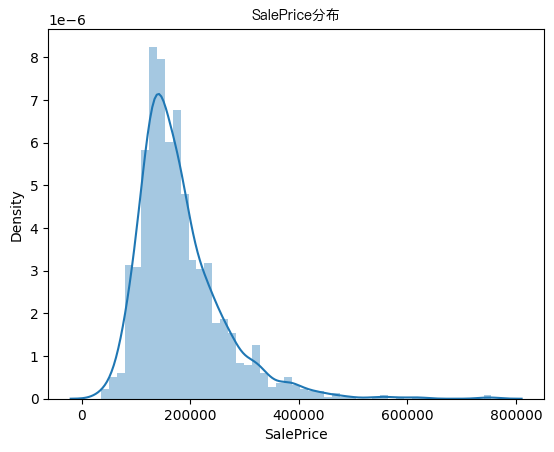

In [12]:
# SalePrice直方图
# seaborn作直方图默认画出密度曲线
plt.figure()
sns.distplot(train_df['SalePrice'])
plt.title('SalePrice分布', fontproperties=ch_font)
plt.show()

通过图中可以看出房价不完全服从正态分布。我们可以查看峰度（Kurtosis）和 偏度（Skewness）两个统计量。

**峰度（Kurtosis）是描述某变量所有取值分布形态陡缓程度的统计量**  
计算公式：β = M_4 /σ^4 偏度
- Kurtosis=0 与正态分布的陡缓程度相同
- Kurtosis>0 比正态分布的高峰陡峭——尖顶峰
- Kurtosis<0 比正态分布的高峰平缓——平顶峰

**偏度（Skewness）是描述某变量取值分布对称性的统计量**  
计算公式： S= (X^ - M_0)/δ
- Skewness=0 分布形态与正态分布偏度相同
- Skewness>0 正偏差数值较大，为正偏或右偏。长尾巴拖在右边
- Skewness<0 负偏差数值较大，为负偏或左偏。长尾巴拖在左边

In [13]:
# 计算峰度和偏度
print('峰度(Kurtosis): ', train_df['SalePrice'].kurt())
print('偏度(Skewness): ', train_df['SalePrice'].skew())

峰度(Kurtosis):  6.536281860064529
偏度(Skewness):  1.8828757597682129


可以看出，SalePrice高峰陡峭，右偏长尾分布。可以对变量做对数变换，使其呈现正常的正态分布。

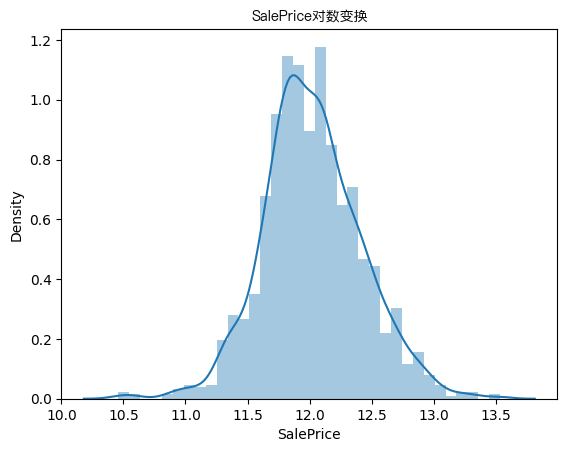

In [14]:
plt.figure()
sns.distplot(np.log(train_df['SalePrice']))
plt.title('SalePrice对数变换', fontproperties=ch_font)
plt.show()

**构建模型时为什么要尽量将偏态数据转换为正态分布数据？**

数据整体服从正态分布，那样本均值和方差则相互独立。正态分布具有很多好的性质，很多模型假设数据服从正态分布。例如线性回归(linear regression)，它假设误差服从正态分布，从而每个样本点出现的概率就可以表示成正态分布的形式，将多个样本点连乘再取对数，就是所有训练集样本出现的条件概率，最大化这个条件概率就是LR要最终求解的问题。这里这个条件概率的最终表达式的形式就是我们熟悉的误差平方和。总之， ML中很多model都假设数据或参数服从正态分布。

**如果不是正态分布怎么办？**

数据右偏的话可以对所有数据取对数、取平方根等，它的原理是因为这样的变换的导数是逐渐减小的，也就是说它的增速逐渐减缓，所以就可以把大的数据向左移，使数据接近正态分布。
如果左偏的话可以取相反数转化为右偏的情况。

### 2.2.2 分析特征变量

#### 2.2.2.1 特征变量分类
特征变量按照数据类型分成定量变量和定性变量

In [15]:
# 定量变量
quantitative = [feature for feature in train_df.columns if train_df.dtypes[feature] != 'object'] 
quantitative.remove('Id')
quantitative.remove('SalePrice')
# 定性变量
qualitative = [feature for feature in train_df.columns if train_df.dtypes[feature] == 'object'] 

#### 2.2.2.2 定量变量分析

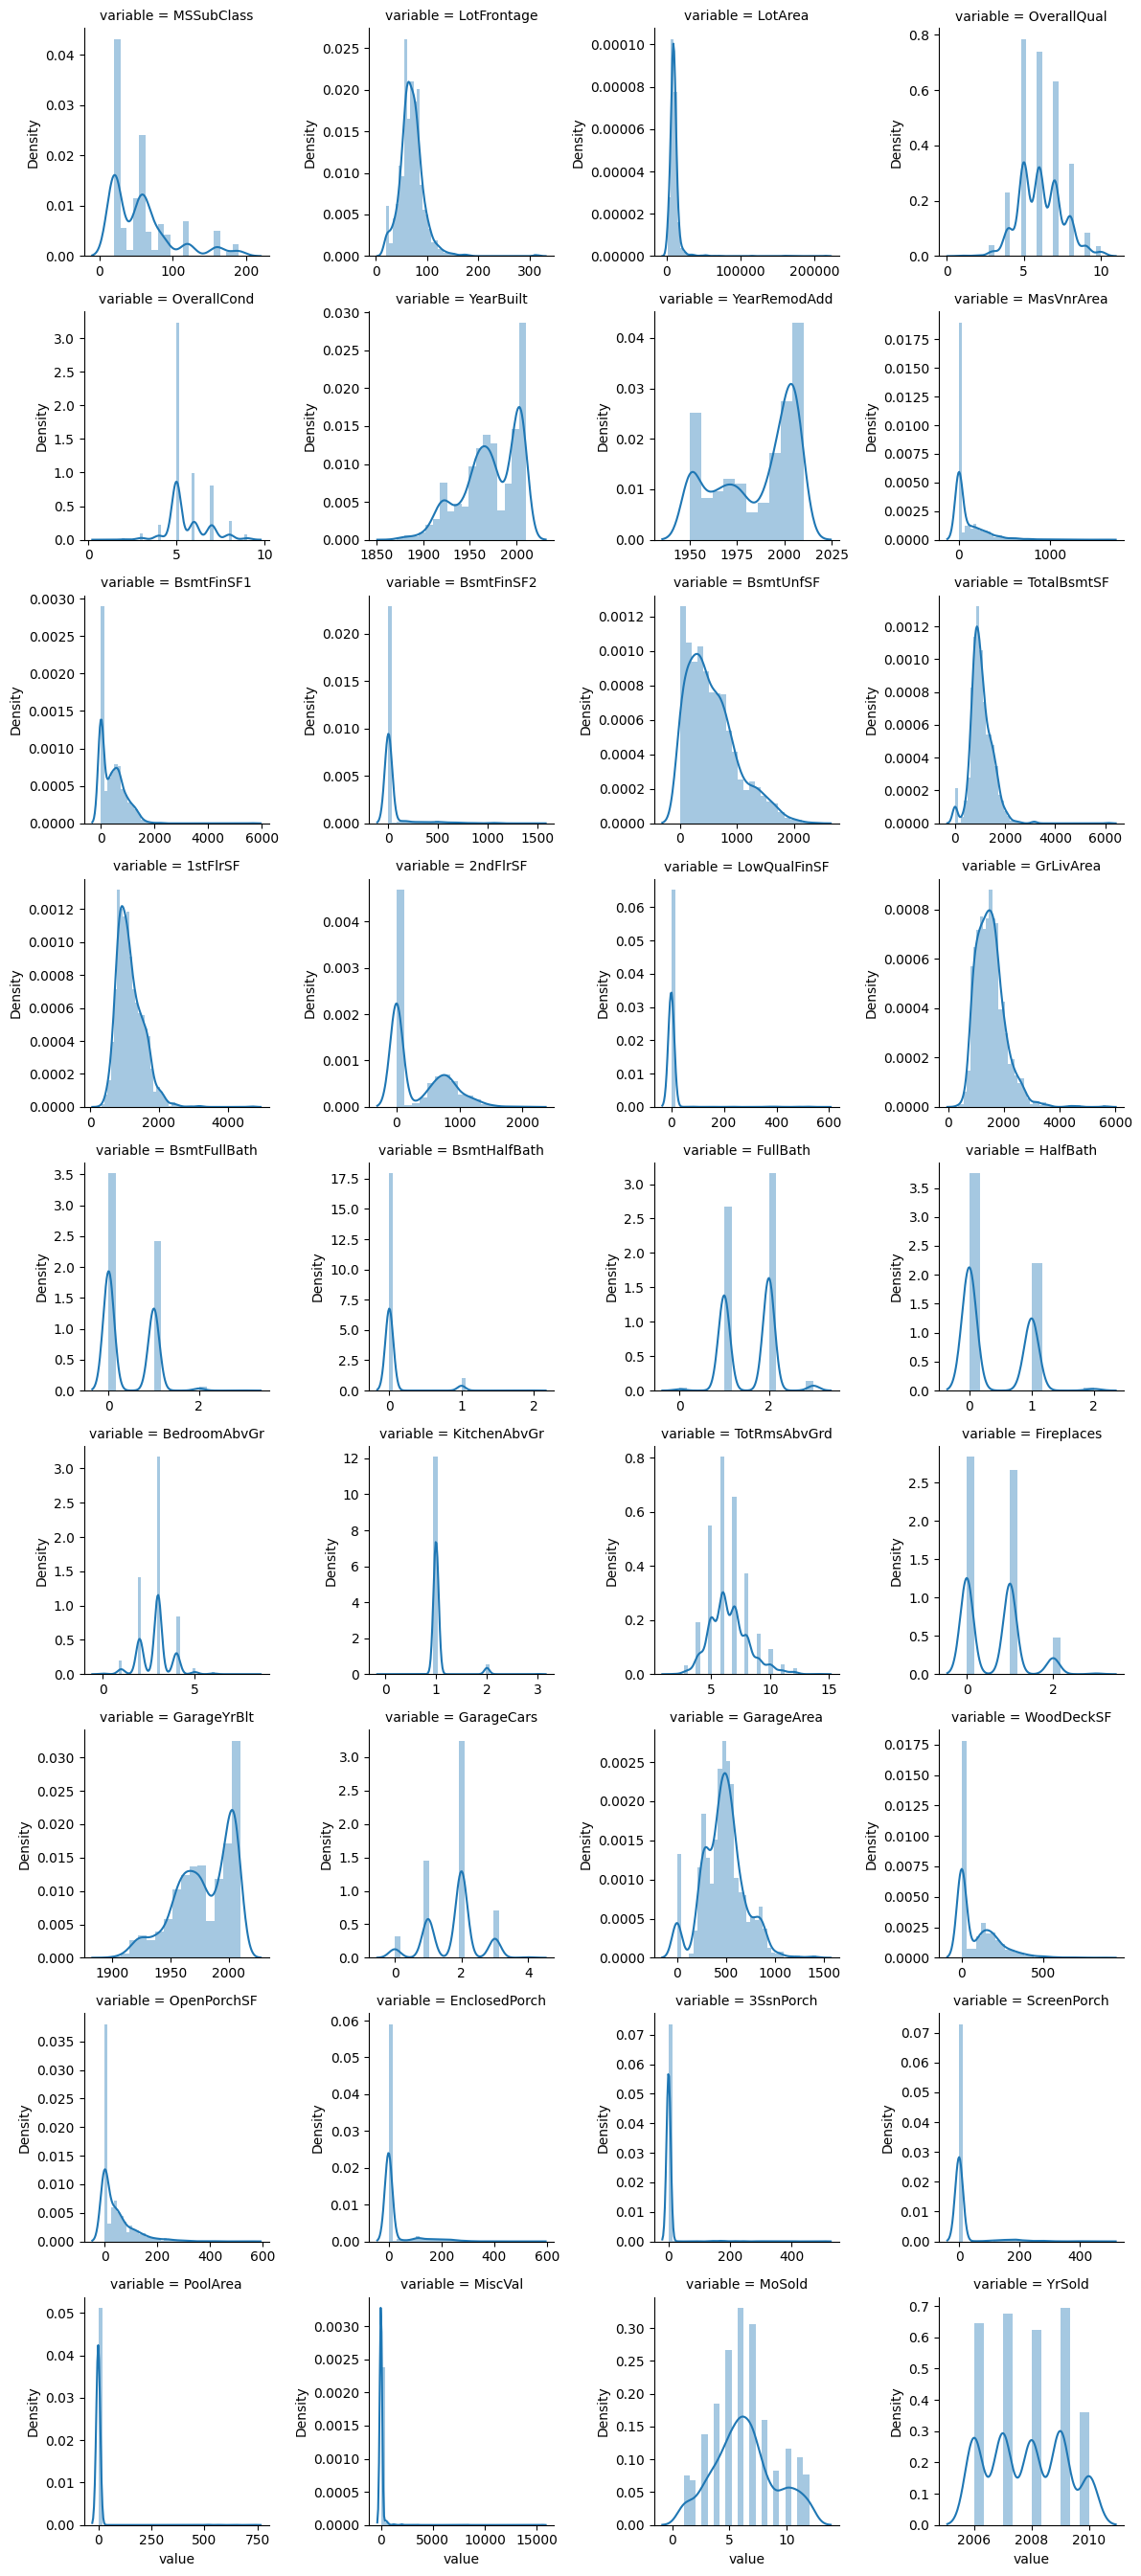

In [16]:
# 定量变量直方图
m_cont = pd.melt(train_df, value_vars=quantitative)
g = sns.FacetGrid(m_cont, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.distplot, 'value')

上图中有些变量类似正态分布，可以做对数变换提升数据质量，适合的对象有LotFrontage, TotalBsmtSF, 1stFlrSF，LotArea, GrLivArea

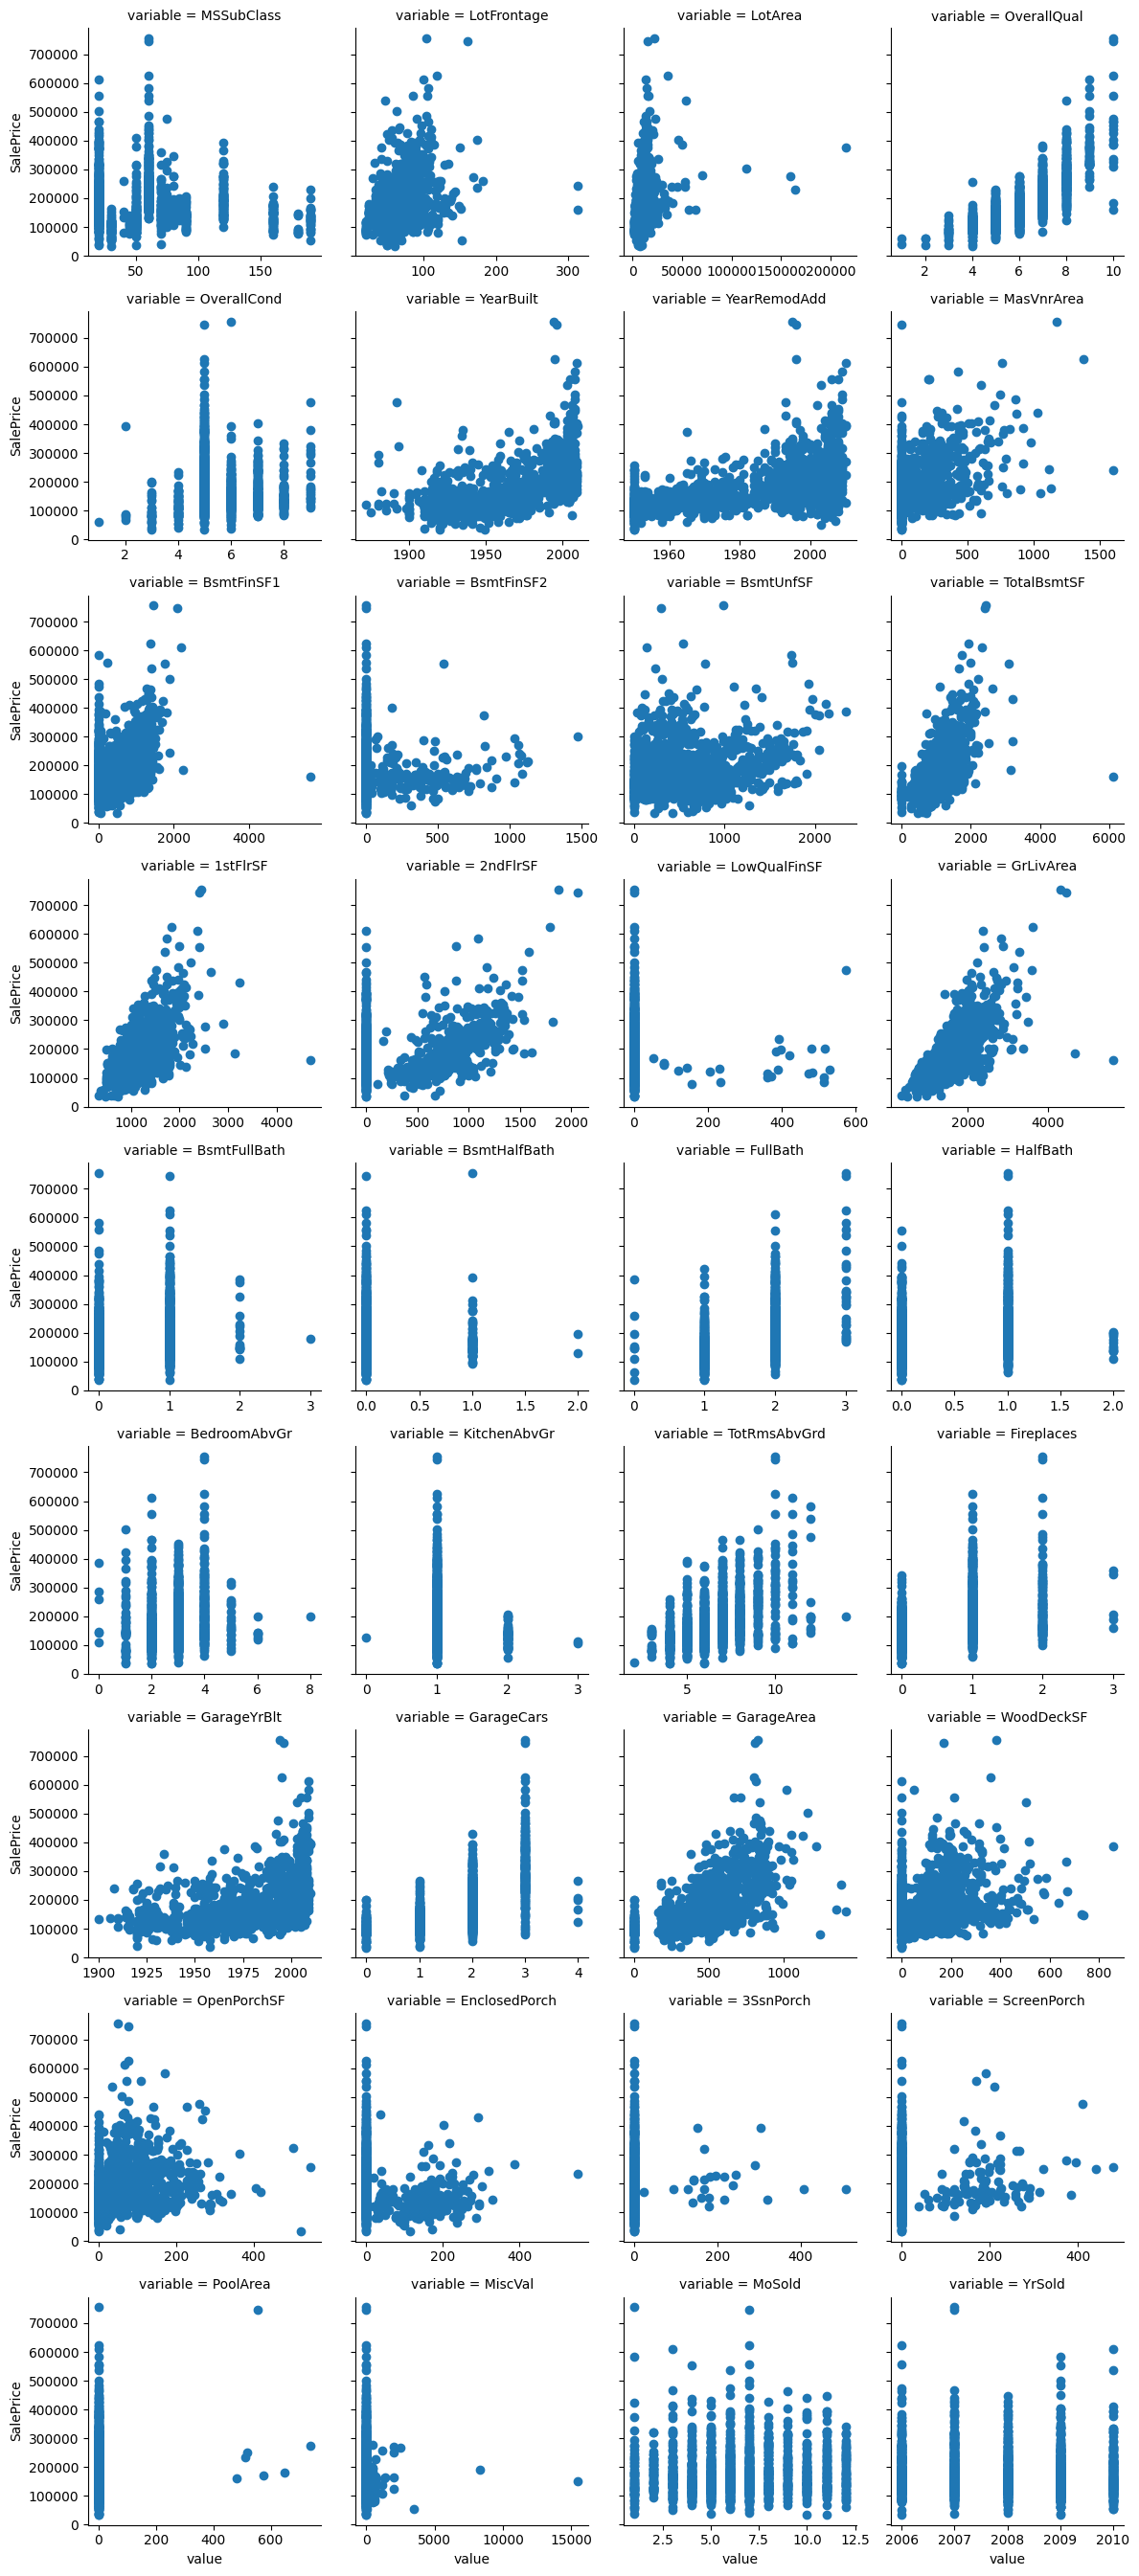

In [17]:
# 定量变量与房价关系图
m_cont = pd.melt(train_df, id_vars='SalePrice', value_vars=quantitative)
g = sns.FacetGrid(m_cont, col='variable', col_wrap=4, sharex=False, sharey=True)
g.map(plt.scatter, 'value', 'SalePrice')

#### 2.2.2.3 定性变量分析

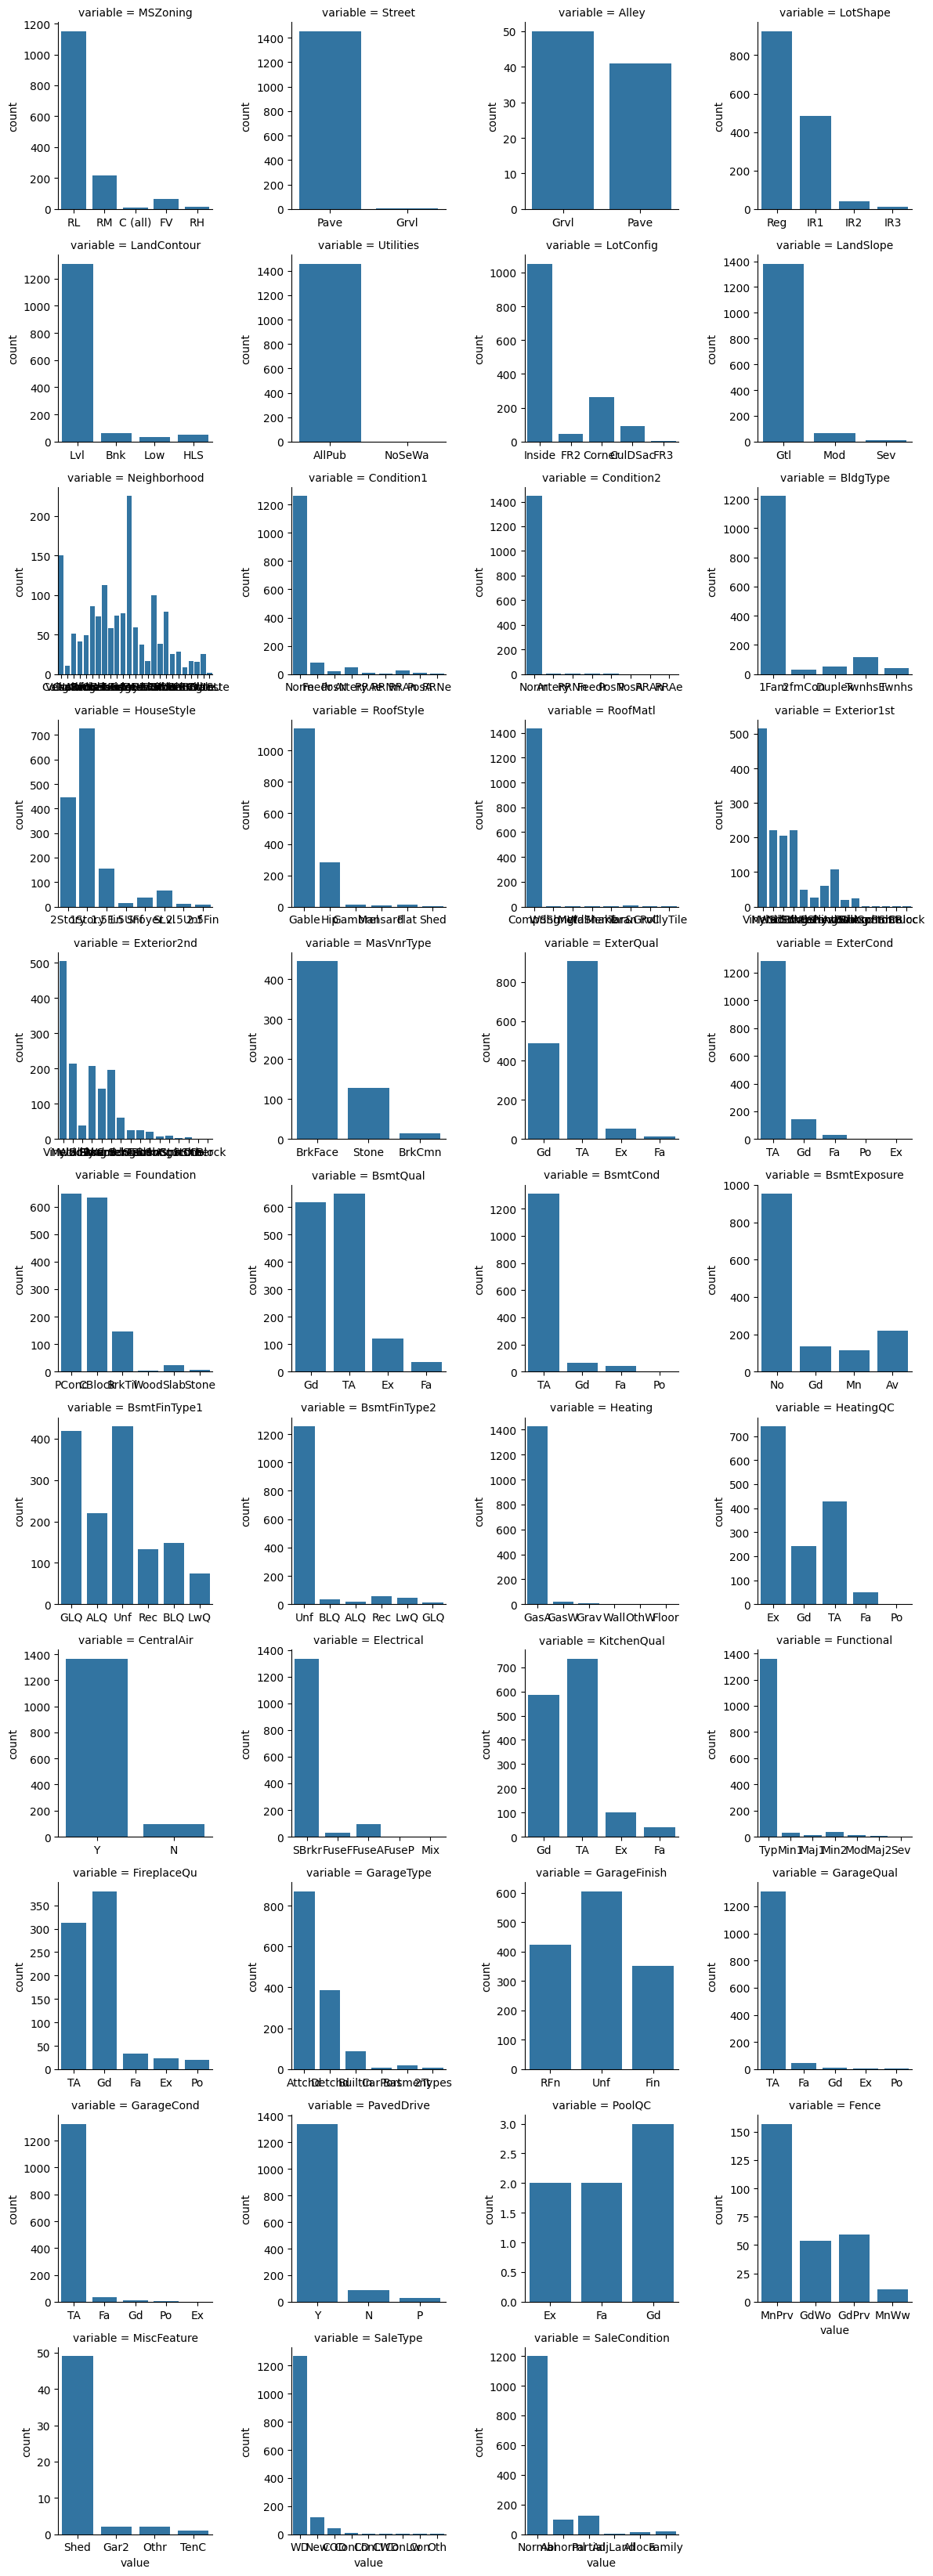

In [18]:
# 定性变量频数统计图
m_disc = pd.melt(train_df, value_vars=qualitative)
g = sns.FacetGrid(m_disc, col='variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.countplot, 'value')

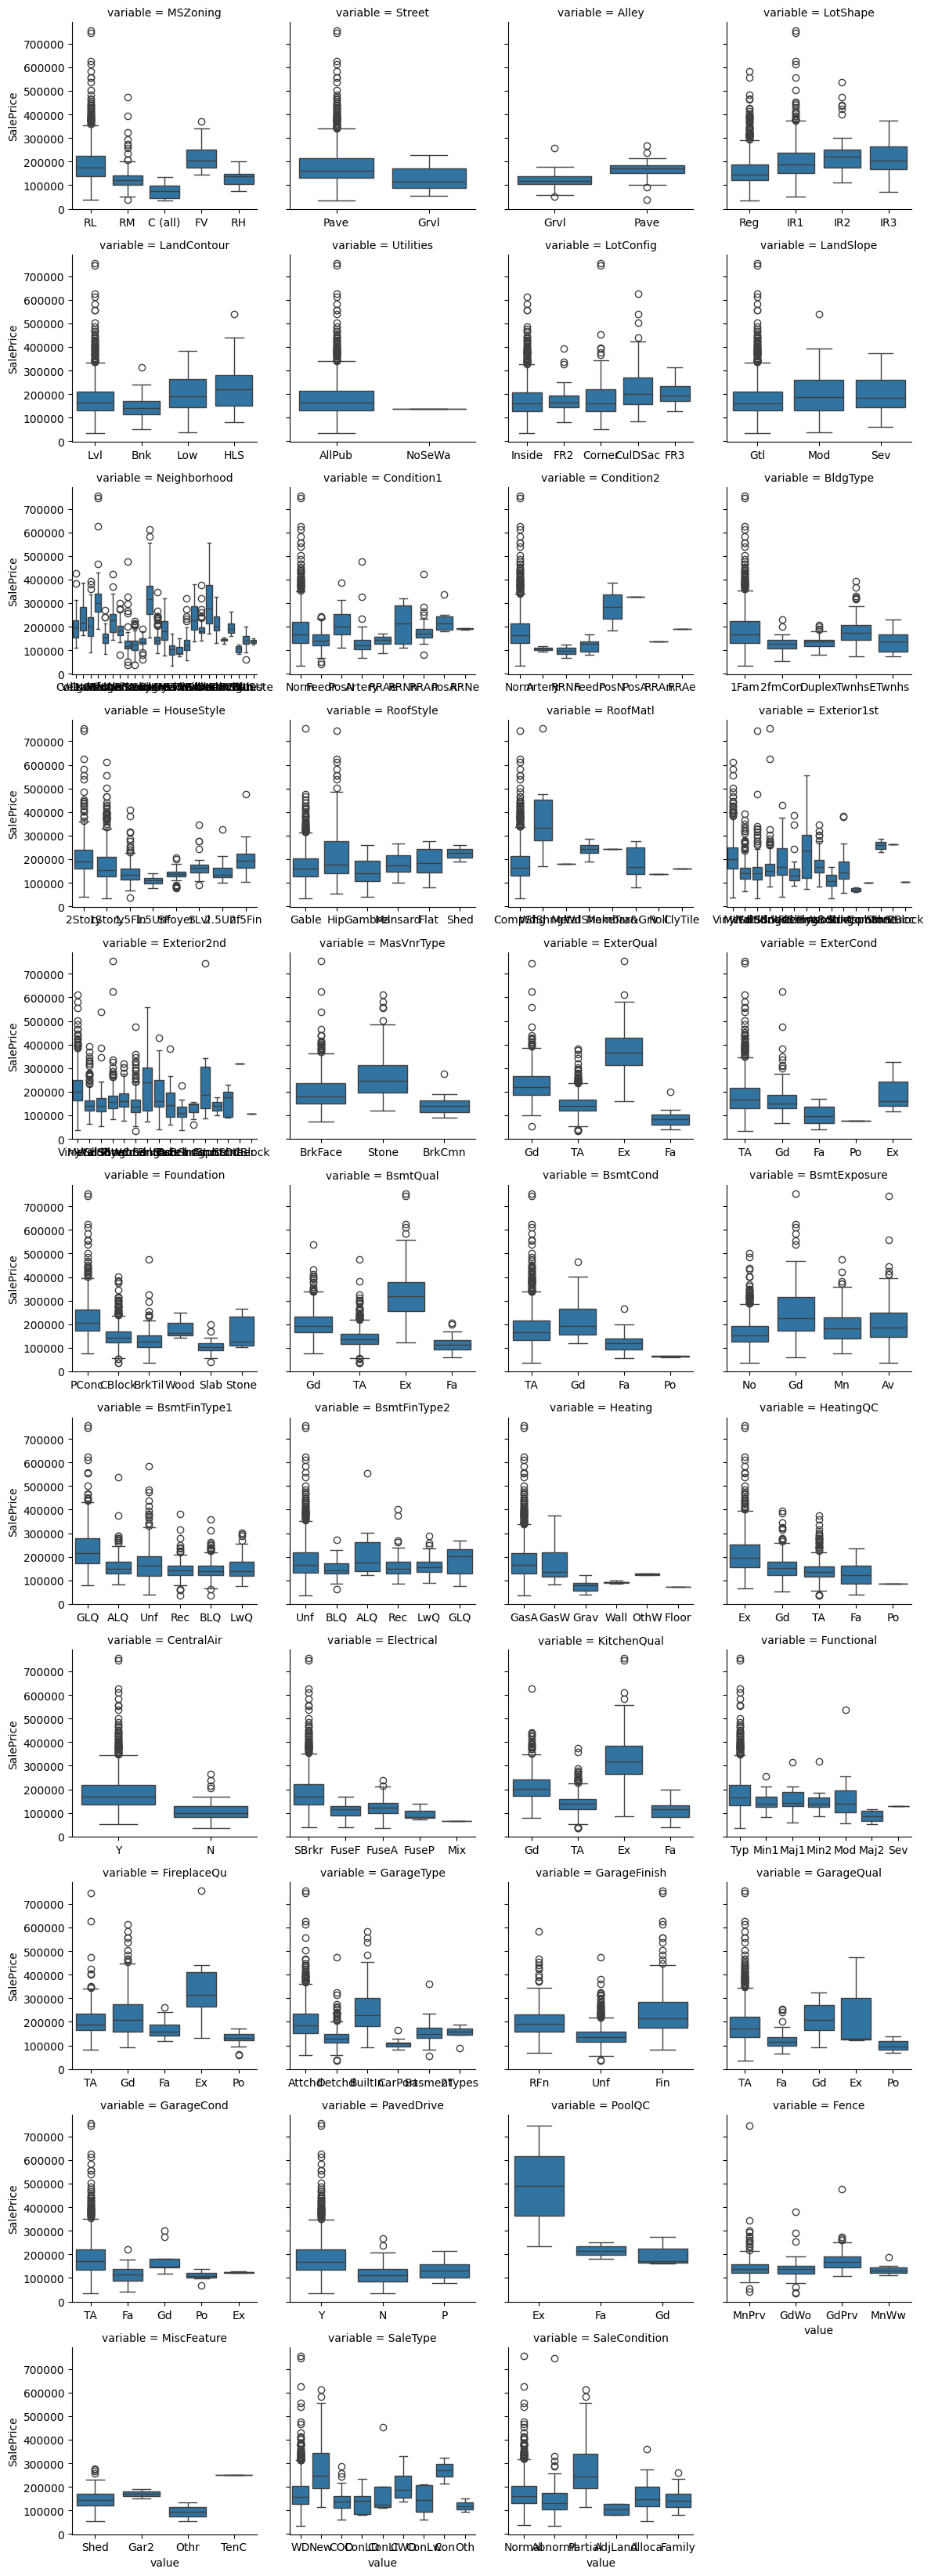

In [19]:
# 定性变量与房价关系图
m_disc = pd.melt(train_df, id_vars='SalePrice', value_vars=qualitative)
g = sns.FacetGrid(m_disc, col='variable', col_wrap=4, sharex=False, sharey=True)
g.map(sns.boxplot, 'value', 'SalePrice')

对定性变量进行单因素方差分析，分析定性变量对SalePrice的影响

**方差分析**（Analysis of Variance，简称ANOVA）又称“变异数分析”或“F检验”，是由R.A.Fister发明的，用于对两个及两个以上的样本集合的统计特性：平均数差别的显著性检验 。

单因素ANOVA也就是单因素方差分析，是用来研究一个控制变量的不同水平是否对观测变量产生了显著影响。通俗地讲就是分析变量x的变化对变量y的影响的显著性，所以一般变量之间存在某种影响关系的，验证一种变量的变化对另一种变量的影响显著性的检验。

Python 实现单因素方差分析使用scipy.stats.f_oneway()方法，传入多个数组，返回F，P

In [20]:
def anova(frame, qualitative):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    p_vals = []
    for fea in qualitative:
        samples = []
        cls = frame[fea].unique() # 变量的类别值
        for c in cls:
            c_array = frame[frame[fea]==c]['SalePrice'].values
            samples.append(c_array)
        p_val = stats.f_oneway(*samples)[1] # 获得p值,p值越小，对SalePrice的显著性影响越大
        p_vals.append(p_val)
    anv['pval'] = p_vals
    return anv.sort_values('pval')

In [21]:
a = anova(train_df, qualitative)
a['disparity'] = np.log(1./a['pval'].values) # 对SalePrice的影响悬殊度
a['description'] = a['feature'].apply(lambda x: descriptions[x])

In [22]:
a

,feature,pval,disparity,description
8,Neighborhood,1.558600e-225,517.637858,房屋在埃姆斯市的位置
18,ExterQual,1.439551e-204,469.363028,外立面材料质量
30,KitchenQual,3.032213e-192,440.987045,厨房质量
20,Foundation,5.791895e-91,207.778784,房屋结构类型
27,HeatingQC,2.667062e-67,153.292224,采暖质量和条件
42,SaleCondition,7.988268e-44,99.235770,出售条件
15,Exterior1st,2.586089e-43,98.061012,外立面材料
16,Exterior2nd,4.842186e-43,97.433793,外立面材料2
41,SaleType,5.039767e-42,95.091214,出售类型
0,MSZoning,8.817634e-35,78.413725,区域分类


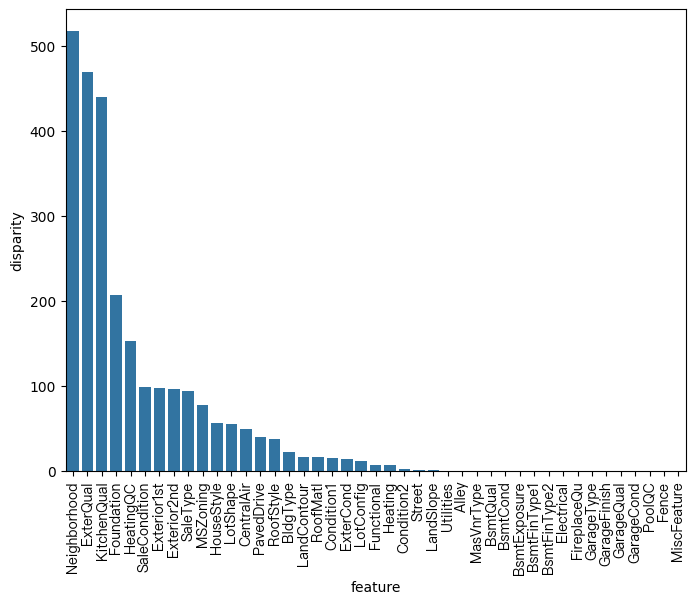

In [23]:
plt.figure(figsize=(8, 6))
sns.barplot(x='feature', y='disparity', data=a)
plt.xticks(rotation=90, fontproperties=ch_font)
plt.show()

对定性变量进行数值化编码。变量每个类别值对应的SalePrice均值排序，相应的对每个类别值赋值1，2，3...

In [24]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering['val']
    ordering['spmean'] = frame[[feature, 'SalePrice']].groupby(feature)['SalePrice'].mean()
    ordering = ordering.sort_values('spmean')
    ordering['ordering'] = np.arange(1, ordering.shape[0]+1)
    ordering = ordering['ordering'].to_dict() # 返回的数据样例{category1:1, category2:2, ...}
    
    # 对frame[feature]编码
    for category, code_value in ordering.items():
        frame.loc[frame[feature]==category, feature+'_E'] = code_value

In [25]:
qual_encoded = []
for qual in qualitative:
    encode(train_df, qual)
    qual_encoded.append(qual+'_E')
print(qual_encoded)
train_df

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,GarageType_E,GarageFinish_E,GarageQual_E,GarageCond_E,PavedDrive_E,PoolQC_E,Fence_E,MiscFeature_E,SaleType_E,SaleCondition_E
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,2.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,2.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,5.0,1.0,3.0,5.0,3.0,NaN,3.0,NaN,5.0,5.0
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,5.0,2.0,3.0,5.0,3.0,NaN,4.0,2.0,5.0,5.0
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,5.0,1.0,3.0,5.0,3.0,NaN,NaN,NaN,5.0,5.0


#### 2.2.2.4 相关性

**查看定性变量与目标变量的spearman相关系数**

`Spearman`相关系数是一种用于衡量两个变量之间的单调关系的非参数统计指标。与皮尔逊相关系数不同，`Spearman`相关系数不要求变量之间的关系是线性的，而是可以捕捉到任何单调的关系，包括非线性的关系。

`Spearman`相关系数的取值范围为`-1`到`1`。以下是对`Spearman`相关系数取值的一般解释：

- 当`Spearman`相关系数为`-1`时，表示变量之间存在完全的负相关关系。即，当一个变量增加时，另一个变量会完全减小，并且变量之间的关系可以通过一个单调递减函数来描述。
- 当`Spearman`相关系数为`0`时，表示变量之间不存在单调关系。即，一个变量的值的变化并不意味着另一个变量的值会发生变化。
- 当`Spearman`相关系数为`1`时，表示变量之间存在完全的正相关关系。即，当一个变量增加时，另一个变量会完全增加，并且变量之间的关系可以通过一个单调递增函数来描述。

`Spearman`相关系数是基于变量的排序顺序进行计算的，而不是直接使用原始变量的值。对于定性变量（也称为分类变量），它们通常没有直接可比较的数值关系。例如，一个定性变量可能是颜色，有"红"、"绿"和"蓝"等等取值，这些取值之间没有明确的大小关系。因此，为了能够计算`Spearman`相关系数，我们需要将定性变量转换为数值表示。编码定性变量可以为每个不同的取值分配一个数值标签，使得不同的取值之间存在一种排序关系。常见的编码方法包括使用整数编码、独热编码（`One-Hot Encoding`）等。

In [26]:
# 计算特征变量与房价的spearman相关系数
def spearman(frame, features):
    spr =  pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame['SalePrice'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(x='spearman', y='feature', data=spr)

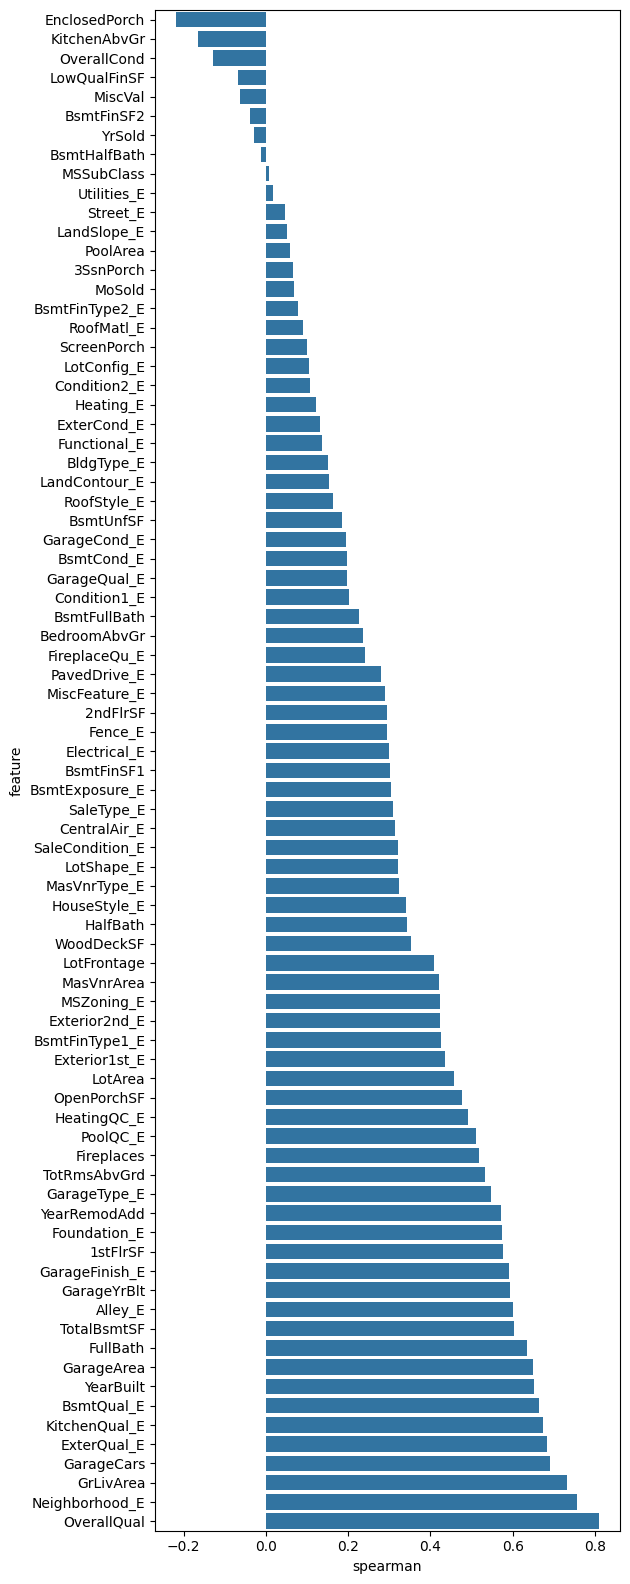

In [27]:
spearman(train_df, quantitative+qual_encoded)

数据集变量间存在非线性关系时，因此使用`spearman`相关系数评价变量之间的相关性。可以看出*OverallQual*,*Neighborhood*与房价间有较大的正相关性，*EnclosedPorch*与房价间有较大的负相关性。

Text(0.5, 1.0, '定量变量和定性变量相关性')

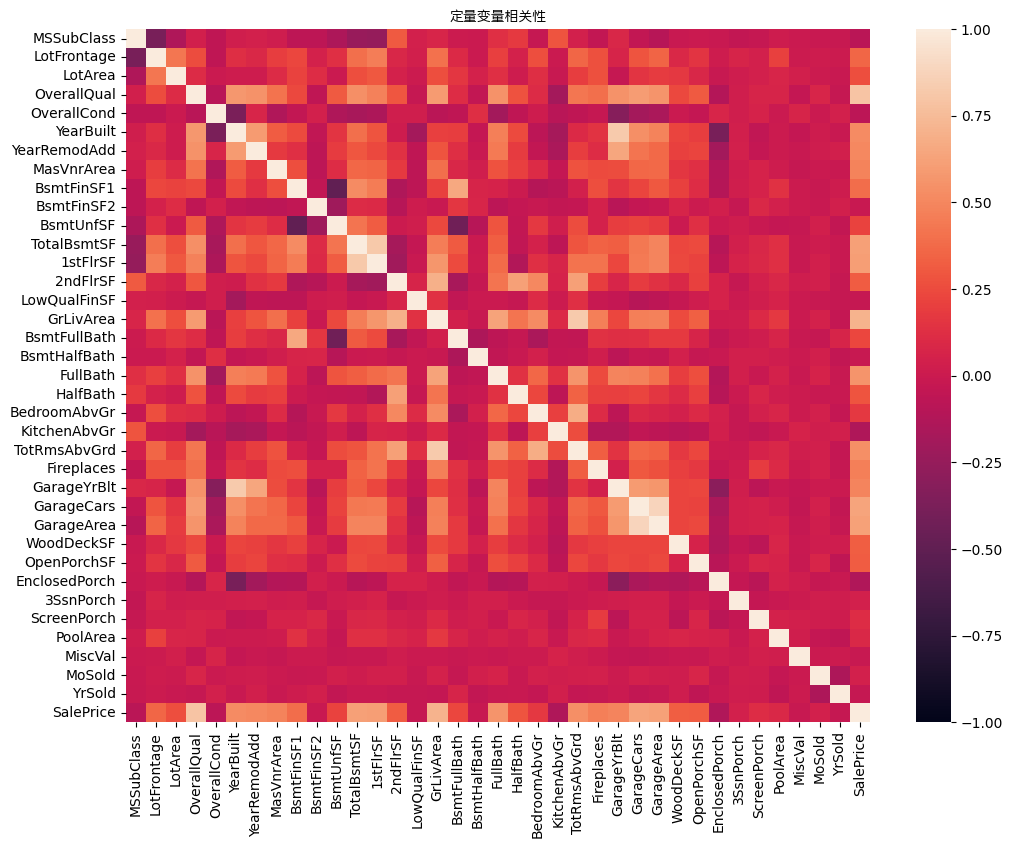

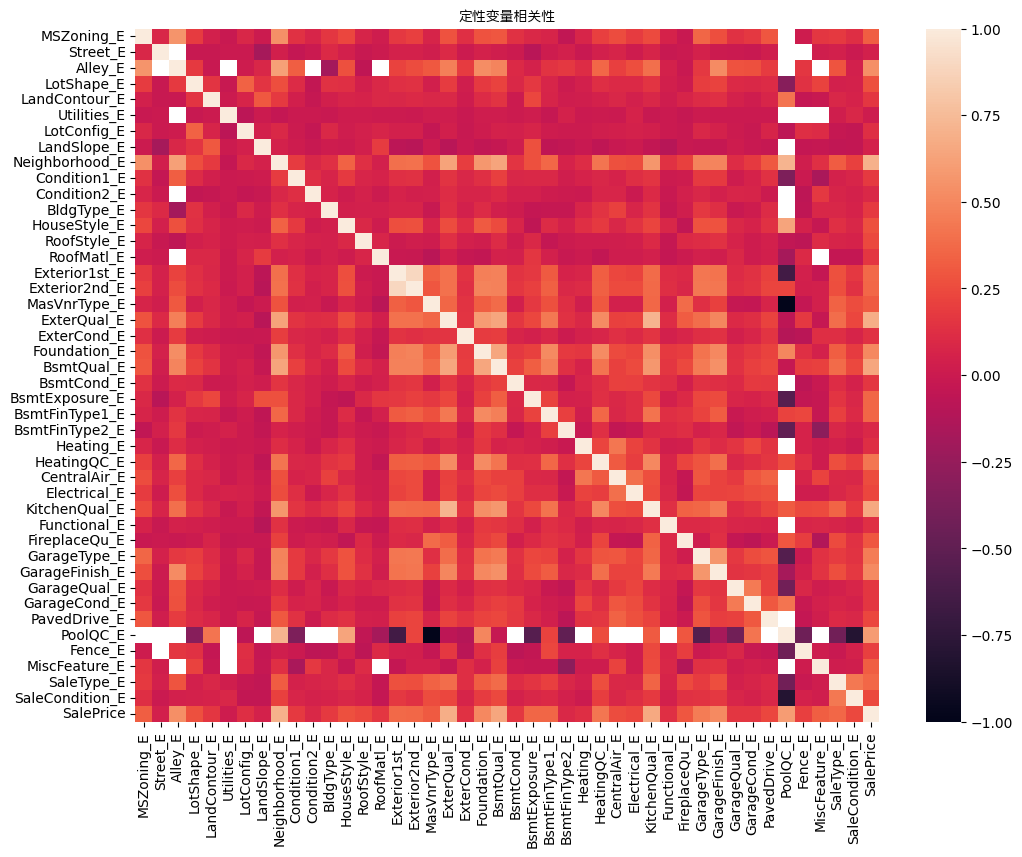

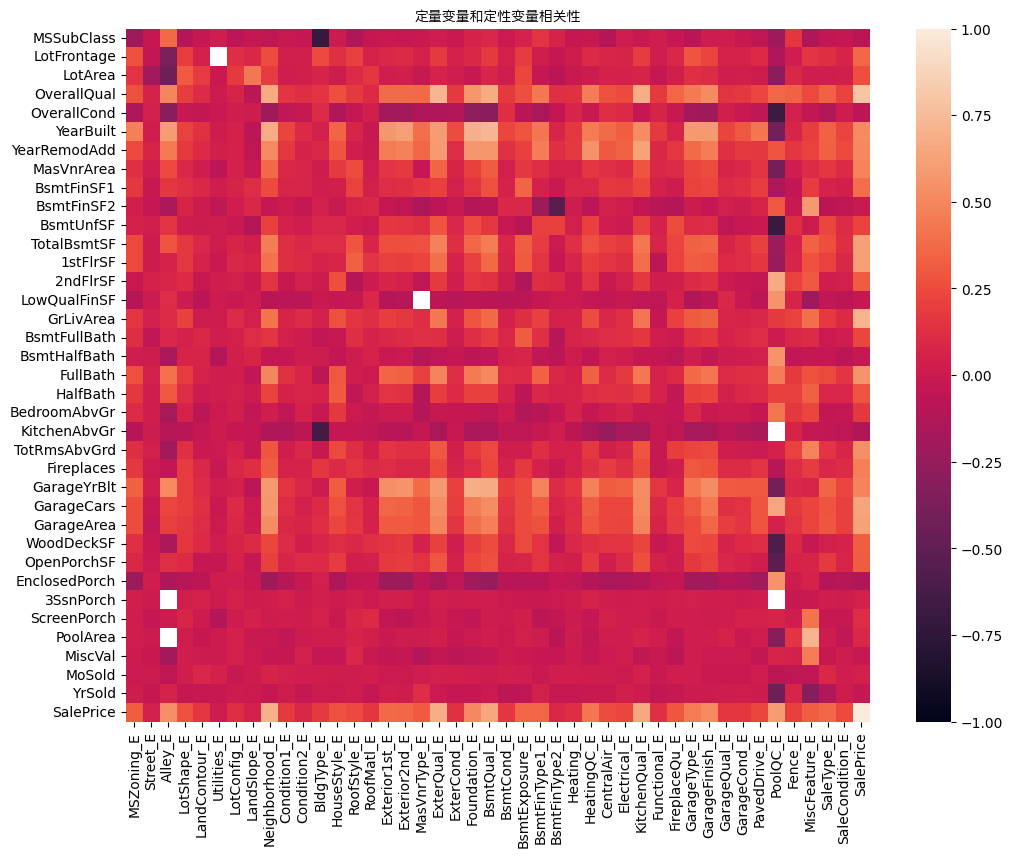

In [28]:
# 分析定量变量之间、定性变量之间、定量变量与定性变量之间的相关性
plt.figure(1, figsize=(12,9))
corr = train_df[quantitative+['SalePrice']].corr()
sns.heatmap(corr, vmin=-1, vmax=1)
plt.title('定量变量相关性', fontproperties=ch_font)

plt.figure(2, figsize=(12,9))
corr = train_df[qual_encoded+['SalePrice']].corr()
sns.heatmap(corr, vmin=-1, vmax=1)
plt.title('定性变量相关性', fontproperties=ch_font)

plt.figure(3, figsize=(12,9))
corr = pd.DataFrame(np.zeros((len(quantitative)+1, len(qual_encoded)+1)), index=quantitative+['SalePrice'], columns=qual_encoded+['SalePrice'])
for q1 in quantitative+['SalePrice']:
    for q2 in qual_encoded+['SalePrice']:
        corr.loc[q1, q2] = train_df[q1].corr(train_df[q2])
sns.heatmap(corr, vmin=-1, vmax=1)
plt.title('定量变量和定性变量相关性', fontproperties=ch_font)

某些变量存在互相关性，在做回归时会导致共线性问题，因此特征选择时只选取其中一个变量。

#### 2.2.2.5 房价分段
房价分成高价格、标准价格两个等级，分析定量变量与不同价格段的关系

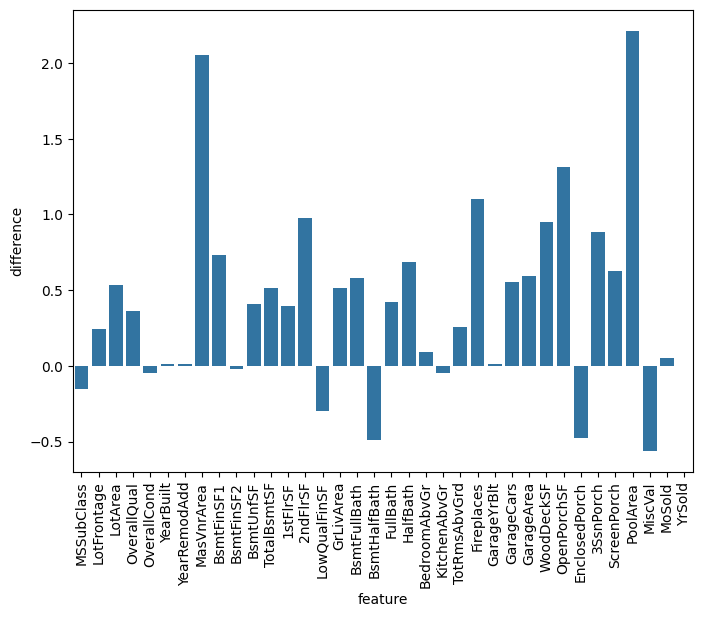

In [29]:
standard = train_df[train_df['SalePrice'] < 200000]
pricey = train_df[train_df['SalePrice'] >= 200000]

features = quantitative

diff = pd.DataFrame()
diff['feature'] = features
# 高的值是低的值的一倍以上
diff['difference'] = [(pricey[f].mean()-standard[f].mean())/standard[f].mean() for f in features]

plt.figure(figsize=(8, 6))
sns.barplot(x='feature', y='difference', data=diff)
plt.xticks(rotation=90)
plt.show()

房价以200000为分界点，价格高的房屋有泳池(PoolArea)，装饰石材(MasVnrArea)，开放门廊(OpenPorchSF)

# 3. 数据清洗

In [30]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

## 3.1 离群点处理

从前面观察分析定量变量与房价关系图看出，GrLivArea存在2个离群点，居住面积大，但是房价低，应该删除。TotalBsmtSF,1stFlrSF,BsmtFinSF1各存在1个离群点，与GrLivArea其中的一个离群点相同。

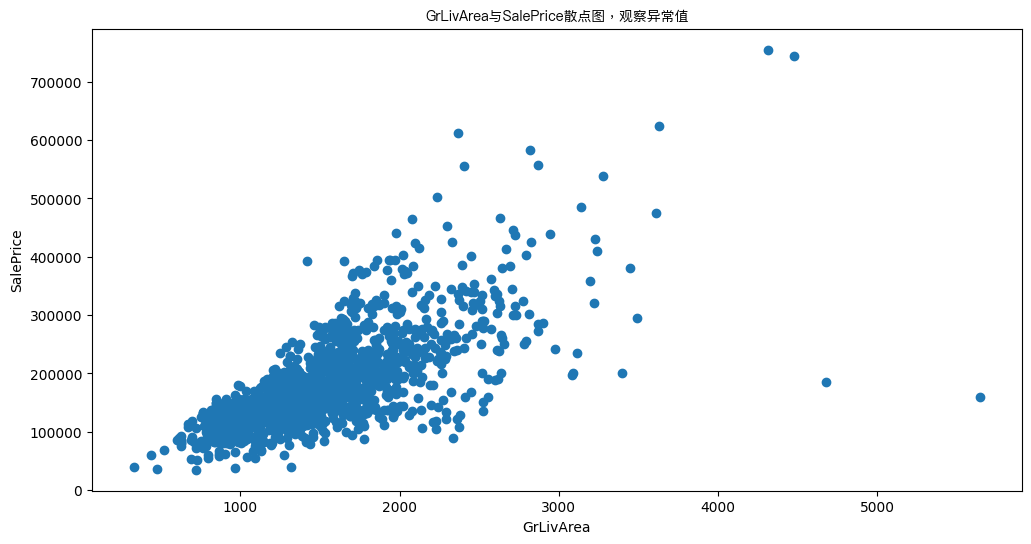

In [31]:
plt.figure(figsize=(12,6))
plt.scatter(train['GrLivArea'], train['SalePrice'])
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea与SalePrice散点图，观察异常值', fontproperties=ch_font)
# plt.grid(b=True, ls=':')
plt.show()

In [32]:
# 删除两个离群点
train.drop(train[(train.GrLivArea>4000) & (train.SalePrice<200000)].index, inplace=True)

In [33]:
# 合并训练集和测试集，便于同时对两个数据集进行数据清洗和特征工程
full = pd.concat([train, test], axis=0, ignore_index=True)

In [34]:
train.shape, test.shape, full.shape

((1458, 81), (1459, 80), (2917, 81))

## 3.2 缺失值处理

In [35]:
# 查看缺失值
missing_count = full.isnull().sum()
missing_count = missing_count[missing_count > 0].sort_values(ascending=False)
missing_rate = missing_count / len(full)

missing = pd.DataFrame()
missing['count'] = missing_count
missing['rate'] = missing_rate

In [36]:
missing

,count,rate
PoolQC,2908,0.996915
MiscFeature,2812,0.964004
Alley,2719,0.932122
Fence,2346,0.804251
MasVnrType,1766,0.605417
SalePrice,1459,0.500171
FireplaceQu,1420,0.486802
LotFrontage,486,0.166610
GarageCond,159,0.054508
GarageYrBlt,159,0.054508


**(1) LotFrontage缺失值处理**

In [37]:
train_df[quantitative+qual_encoded].corr('spearman')['LotFrontage'].sort_values(ascending=False)

LotFrontage      1.000000
LotArea          0.649633
1stFlrSF         0.427678
TotalBsmtSF      0.386206
BldgType_E       0.382984
                   ...   
OverallCond     -0.083242
EnclosedPorch   -0.095811
MSSubClass      -0.314265
Alley_E         -0.343520
Utilities_E           NaN
Name: LotFrontage, Length: 79, dtype: float64

可以看出LotFrontage与LotArea,Neighborhood相关性较大，不过LotArea是连续变量，这里对其区间分段，最后使用每个分组的中位数填补

In [38]:
full['LotAreaCut'] = pd.qcut(full['LotArea'], 10)
full['LotAreaCut']

0          (7949.0, 8740.4]
1         (9452.0, 10148.8]
2        (11000.0, 12196.8]
3         (9452.0, 10148.8]
4        (12196.8, 14285.8]
               ...         
2912     (1299.999, 4921.8]
2913     (1299.999, 4921.8]
2914    (14285.8, 215245.0]
2915     (10148.8, 11000.0]
2916      (9452.0, 10148.8]
Name: LotAreaCut, Length: 2917, dtype: category
Categories (10, interval[float64, right]): [(1299.999, 4921.8] < (4921.8, 7007.2] < (7007.2, 7949.0] < (7949.0, 8740.4] ... (10148.8, 11000.0] < (11000.0, 12196.8] < (12196.8, 14285.8] < (14285.8, 215245.0]]

In [39]:
full.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].agg(['count', 'mean', 'median'])

count       mean  median
LotAreaCut          Neighborhood                          
(1299.999, 4921.8]  Blmngtn          20  46.900000    43.0
                    Blueste          10  27.300000    24.0
                    BrDale           30  21.500000    21.0
                    BrkSide           4  52.000000    51.0
                    ClearCr           0        NaN     NaN
...                                 ...        ...     ...
(14285.8, 215245.0] SawyerW           5  84.600000    90.0
                    Somerst           5  61.600000    49.0
                    StoneBr          11  73.363636    63.0
                    Timber           12  95.916667    89.0
                    Veenker           7  86.857143    95.0

[250 rows x 3 columns]

In [40]:
def lot_frontage_fillna(x):
  # print('len =', len(x))
  print('x =', x)
  x.fillna(x.median())

full['LotFrontage'] = full.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
# full['LotFrontage'] = full.groupby(['LotAreaCut', 'Neighborhood'])['LotFrontage'].transform(lot_frontage_fillna)

In [41]:
# 由于某些分组没有数据，因此未填补的缺失值单独利用LotAreaCut填充
full['LotFrontage'] = full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))

**(2) 某些类别变量有缺失值是因为没有这个属性，填补None**  
比如PoolQC(泳池质量)，缺失值是因为这个房子没有泳池

In [42]:
cols = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish", "GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col in cols:
    full[col] = full[col].fillna('None')

**(3)某些数值变量有缺失值是因为没有这个属性，填补0**  
比如GarageArea(车库面积)，缺失值是因为这个房子没有车库

In [43]:
cols2 = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in cols2:
    full[col] = full[col].fillna(0)

**(4)其他缺失值变量都是离散变量，缺失值数目较少，用众数填补**

In [44]:
cols3 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional", "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]
for col in cols3:
    full[col] = full[col].fillna(full[col].mode()[0])

**(5)检查有无缺失值**

In [45]:
full.isnull().sum()[full.isnull().sum()>0] # 缺失值填补完毕

SalePrice    1459
dtype: int64

In [46]:
full.drop('LotAreaCut', axis=1, inplace=True)

In [47]:
full.shape

(2917, 81)

# 4. 特征工程

## 4.1 某些数值特征转化为类别特征
一些数值特征表示的意义是类别属性，比如MSSubClass(建筑等级)，这里将其转换为字符串，便于进行标签编码和独热编码。

In [48]:
Num_to_Str = ['MSSubClass', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'MoSold', 'YrSold']
for col in Num_to_Str:
    full[col] = full[col].astype(str)

## 4.2 有序特征编码
在类别变量中有些是有序的，比如HeatingQC(采暖质量)取值: Ex,Gd,TA,Fa,Po，把质量从优到差分为了5个等级。有序特征不适合标签编码(LabelEncode)，它无法识别特征的顺序关系，需要自定义函数进行编码转换。

有些特征进行编码映射可以采取这样的策略：使用该特征对SalePrice分组，根据每组的均值或者中位数进行编码。

以特征MSSubClass为例

In [49]:
full.groupby(['MSSubClass'])['SalePrice'].agg(['count', 'mean', 'median']).sort_values('median')

,count,mean,median
MSSubClass,,,
180,10,102300.000000,88500.0
30,69,95829.724638,99900.0
45,12,108591.666667,107500.0
190,30,129613.333333,128250.0
50,144,143302.972222,132000.0
90,52,133541.076923,135980.0
85,20,147810.000000,140750.0
40,4,156125.000000,142500.0
160,63,138647.380952,146000.0


可以根据SalePrice的分组median编码如下：  
 '180' : 1  
 '30' : 2 ,  '45' : 2  
 '190' : 3, '50' : 3, '90' : 3  
 '85' : 4, '40' : 4, '160' : 4  
 '70' : 5, '20' : 5, '75' : 5, '80' : 5, '150' : 5  
 '120': 6, '60' : 6

In [50]:
# 定义映射函数
def map_values(df):
    df['MSSubClass'] = df['MSSubClass'].map({'180':1,
                                             '30':2, '45':2,
                                             '190':3, '50':3, '90':3, 
                                             '85':4, '40':4, '160':4, 
                                             '70':5, '20':5, '75':5, '80':5, '150':5,
                                             '120': 6, '60':6})
    
    df['MSZoning'] = df['MSZoning'].map({'C (all)':1, 'RM':2, 'RH':2, 'RL':3, 'FV':4})
    
    df['Neighborhood'] = df['Neighborhood'].map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})
    
    df['HouseStyle'] = df['HouseStyle'].map({'1.5Unf':1, 
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2, 
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})
    
    df['MasVnrType'] = df['MasVnrType'].map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})
    
    df['ExterQual'] = df['ExterQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['ExterCond'] = df['ExterCond'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Foundation'] = df['Foundation'].map({'Slab':1, 'BrkTil':2, 'CBlock':2, 'Stone':2, 'Wood':3, 'PConc':4})
    
    df['BsmtQual'] = df['BsmtQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['BsmtCond'] = df['BsmtCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['BsmtExposure'] = df['BsmtExposure'].map({'None':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5})
    
    df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})
    
    df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})
    
    df['HeatingQC'] = df['HeatingQC'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['KitchenQual'] = df['KitchenQual'].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Functional'] = df['Functional'].map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})
    
    df['FireplaceQu'] = df['FireplaceQu'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['GarageFinish'] = df['GarageFinish'].map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})
    
    df['GarageQual'] = df['GarageQual'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['GarageCond'] = df['GarageCond'].map({'None':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})
    
    df['PavedDrive'] = df['PavedDrive'].map({'N':1, 'P':2, 'Y':3})
    
    df['PoolQC'] = df['PoolQC'].map({'None':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
    
    df['Fence'] = df['Fence'].map({'None':1, 'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5})

In [51]:
# 有序特征编码
map_values(full)

## 4.3 时间特征编码

 前面把数据集的时间特征变量转换成了类别变量，但是YearBuilt,YearRemodAdd,GarageYrBlt类别值太多，分别是118,61,104，直接作为类别变量不合适，这里做一下标签编码

In [52]:
lab = LabelEncoder()
full['YearBuilt'] = lab.fit_transform(full['YearBuilt'])
full['YearRemodAdd'] = lab.fit_transform(full['YearRemodAdd'])
full['GarageYrBlt'] = lab.fit_transform(full['GarageYrBlt'])

## 4.4 数据转换

In [53]:
full.drop(['SalePrice', 'Id'], axis=1, inplace=True)

In [54]:
# 数据做一备份
full_fe = full.copy()

In [55]:
full_fe.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,6,3,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,1,1,None,0,2,2008,WD,Normal
1,5,3,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,1,1,None,0,5,2007,WD,Normal
2,6,3,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,1,1,None,0,9,2008,WD,Normal
3,5,3,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,1,1,None,0,2,2006,WD,Abnorml
4,6,3,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,1,1,None,0,12,2008,WD,Normal


In [56]:
# 对于偏度大于1的定量变量进行对数变换
full_numeric = full_fe.select_dtypes(exclude='object')
skew = full_numeric.apply(lambda x: x.skew())
skew_features = skew[abs(skew) >= 1].index
full_fe[skew_features] = np.log1p(full_fe[skew_features])

## 4.5 one-hot编码
对定性变量进行one-hot编码

In [57]:
full_fe = pd.get_dummies(full_fe)

In [58]:
full_fe.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,6,3,65.0,9.042040,7,4,7,5,110,53,...,False,False,False,True,False,False,False,False,True,False
1,5,3,80.0,9.169623,8,3,6,8,83,26,...,False,False,False,True,False,False,False,False,True,False
2,6,3,68.0,9.328212,7,4,7,5,108,52,...,False,False,False,True,False,False,False,False,True,False
3,5,3,60.0,9.164401,7,4,7,5,25,20,...,False,False,False,True,True,False,False,False,False,False
4,6,3,84.0,9.565284,10,4,8,5,107,50,...,False,False,False,True,False,False,False,False,True,False


## 4.6 RobustScaler
考虑到可能存在其他离群点，使用RobustScaler进行区间缩放

In [59]:
scaler = RobustScaler()

In [60]:
# 分离训练集和测试集
n_train = train.shape[0]
train_X = full_fe[:n_train]
test_X = full_fe[n_train:]
train_y = train['SalePrice']

In [61]:
# 区间缩放
# 注意事项：不能分别对训练集和测试集训练与转换，应该在训练集上训练，在测试集上转换
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
train_y = np.log(train_y)

## 4.7 特征选择
这里使用Lasso模型进行特征选择

In [62]:
lasso = Lasso(alpha=0.001)
lasso.fit(train_X, train_y)

Lasso(alpha=0.001)

In [63]:
lasso_fi = pd.DataFrame({'feature_importance':lasso.coef_}, index=full_fe.columns)

In [64]:
lasso_fi.sort_values('feature_importance', ascending=False)

,feature_importance
OverallQual,0.113974
GrLivArea,0.101174
2ndFlrSF,0.083432
YearBuilt,0.070126
1stFlrSF,0.060183
...,...
YrSold_2009,-0.007397
Condition1_Artery,-0.007680
BsmtUnfSF,-0.009012
CentralAir_N,-0.039163


<Figure size 640x480 with 0 Axes>

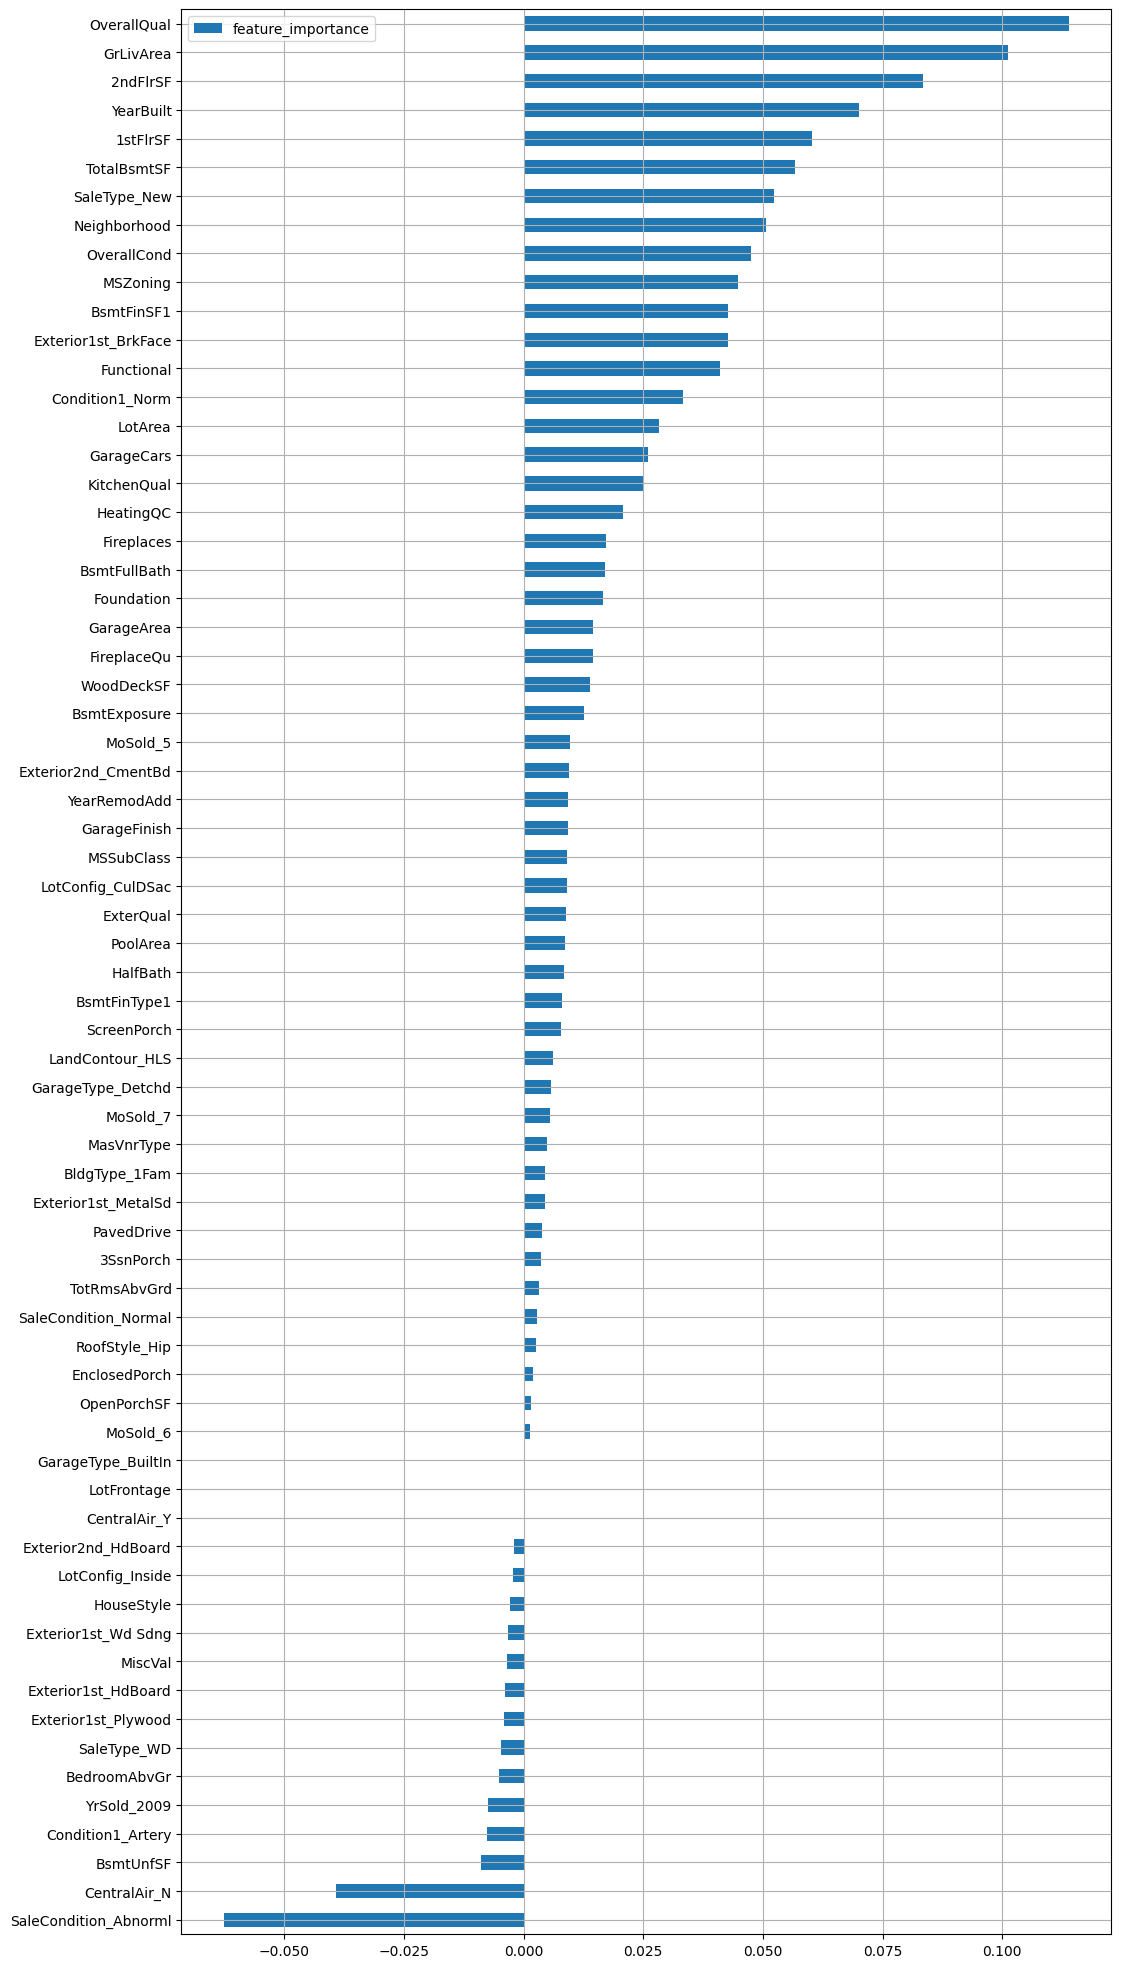

In [65]:
plt.figure()
lasso_fi[lasso_fi['feature_importance'] != 0].sort_values('feature_importance').plot(kind='barh', figsize=(12, 25))
plt.grid()
plt.show()

根据Lasso选出的重要特征进行特征组合，生成新的特征

In [66]:
def add_feature(X):
    X['TotalHouse'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
    X['TotalArea'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF'] + X['GarageArea']
    X['TotalQuality'] = X['OverallQual'] + X['OverallCond']
    
    X['TotalHouse_OverallQual'] = X['TotalHouse'] * X['OverallQual']
    X['GrLivArea_OverallQual'] = X['GrLivArea'] * X['OverallQual']
    X['MSZoning_TotalHouse'] = X['MSZoning'] * X['TotalHouse']
    X['MSZoning_OverallQual'] = X['MSZoning'] + X['OverallQual']
    X['MSZoning_YearBuilt'] = X['MSZoning'] + X['YearBuilt']
    X['Neighborhood_TotalHouse'] = X['Neighborhood'] * X['TotalHouse']
    X['Neighborhood_OverallQual'] = X['Neighborhood'] + X['OverallQual']
    X['Neighborhood_YearBuilt'] = X['Neighborhood'] + X['YearBuilt']
    X['BsmtFinSF1_OverallQual'] = X['BsmtFinSF1'] * X['OverallQual']
    X['Functional_TotalHouse'] = X['Functional'] * X['TotalHouse']
    X['Functional_OverallQual'] = X['Functional'] + X['OverallQual']
    X['LotArea_OverallQual'] = X['LotArea'] * X['OverallQual']
    X['LotArea_TotalHouse'] = X['LotArea'] + X['TotalHouse']
    
    X['Bsmt'] = X['BsmtFinSF1'] + X['BsmtFinSF2'] + X['BsmtUnfSF']
    X['PorchArea'] = X['OpenPorchSF'] + X['EnclosedPorch'] + X['3SsnPorch'] + X['ScreenPorch']
    
    X['TotalPlace'] = X['TotalArea'] + X['PorchArea']

In [67]:
# 获取原数据
full_fe1 = full.copy()

In [68]:
full_fe1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,6,3,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,0,0,1,1,None,0,2,2008,WD,Normal
1,5,3,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,0,0,1,1,None,0,5,2007,WD,Normal
2,6,3,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,0,0,1,1,None,0,9,2008,WD,Normal
3,5,3,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,0,0,1,1,None,0,2,2006,WD,Abnorml
4,6,3,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,0,0,1,1,None,0,12,2008,WD,Normal


In [69]:
full_fe1.shape

(2917, 79)

In [70]:
# 增加特征
add_feature(full_fe1)

In [71]:
full_fe1.shape

(2917, 98)

In [72]:
full_fe1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Neighborhood_OverallQual,Neighborhood_YearBuilt,BsmtFinSF1_OverallQual,Functional_TotalHouse,Functional_OverallQual,LotArea_OverallQual,LotArea_TotalHouse,Bsmt,PorchArea,TotalPlace
0,6,3,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,...,14,117,4942.0,7698.0,10,59150,11016.0,856.0,61,3175.0
1,5,3,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,...,14,91,5868.0,7572.0,9,57600,12124.0,1262.0,0,2984.0
2,6,3,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,...,14,115,3402.0,8118.0,10,78750,13956.0,920.0,42,3356.0
3,5,3,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,...,14,32,1512.0,7419.0,10,66850,12023.0,756.0,307,3422.0
4,6,3,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,...,18,117,5240.0,10029.0,11,114080,17603.0,1145.0,84,4263.0


In [73]:
# 数据转换
full_numeric1 = full_fe1.select_dtypes(exclude='object')
skew1 = full_numeric1.apply(lambda x: x.skew())
skew_features1 = skew1[abs(skew1) >= 1].index
full_fe1[skew_features1] = np.log1p(full_fe1[skew_features1])

In [74]:
full_fe1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Neighborhood_OverallQual,Neighborhood_YearBuilt,BsmtFinSF1_OverallQual,Functional_TotalHouse,Functional_OverallQual,LotArea_OverallQual,LotArea_TotalHouse,Bsmt,PorchArea,TotalPlace
0,6,3,65.0,9.042040,Pave,None,Reg,Lvl,AllPub,Inside,...,14,117,8.505728,7698.0,10,10.987849,9.307195,856.0,4.127134,3175.0
1,5,3,80.0,9.169623,Pave,None,Reg,Lvl,AllPub,FR2,...,14,91,8.677440,7572.0,9,10.961295,9.403025,1262.0,0.000000,2984.0
2,6,3,68.0,9.328212,Pave,None,IR1,Lvl,AllPub,Inside,...,14,115,8.132413,8118.0,10,11.274046,9.543736,920.0,3.761200,3356.0
3,5,3,60.0,9.164401,Pave,None,IR1,Lvl,AllPub,Corner,...,14,32,7.321850,7419.0,10,11.110222,9.394660,756.0,5.730100,3422.0
4,6,3,84.0,9.565284,Pave,None,IR1,Lvl,AllPub,FR2,...,18,117,8.564268,10029.0,11,11.644664,9.775881,1145.0,4.442651,4263.0


In [75]:
# one-hot编码
full_fe1 = pd.get_dummies(full_fe1)

In [76]:
full_fe1.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,6,3,65.0,9.042040,7,4,7,5,110,53,...,False,False,False,True,False,False,False,False,True,False
1,5,3,80.0,9.169623,8,3,6,8,83,26,...,False,False,False,True,False,False,False,False,True,False
2,6,3,68.0,9.328212,7,4,7,5,108,52,...,False,False,False,True,False,False,False,False,True,False
3,5,3,60.0,9.164401,7,4,7,5,25,20,...,False,False,False,True,True,False,False,False,False,False
4,6,3,84.0,9.565284,10,4,8,5,107,50,...,False,False,False,True,False,False,False,False,True,False


In [77]:
full_fe1.shape

(2917, 221)

In [78]:
# 分离训练集和测试集
n_train = train.shape[0]
train_X = full_fe1[:n_train]
test_X = full_fe1[n_train:]
train_y = train.SalePrice

In [79]:
train_X.shape, test_X.shape, train_y.shape

((1458, 221), (1459, 221), (1458,))

In [80]:
# robustscaler
scaler = RobustScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)
train_y = np.log(train_y)

In [81]:
train_X[:5]

array([[ 0.5 ,  0.  , -0.25, ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 , ...,  0.  ,  0.  ,  0.  ],
       [ 0.5 ,  0.  , -0.1 , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -0.5 , ...,  0.  , -1.  ,  0.  ],
       [ 0.5 ,  0.  ,  0.7 , ...,  0.  ,  0.  ,  0.  ]])

## 4.8 PCA
增加的特征与原始特征高度相关，可能导致较强的多重共线性，使用PCA去相关性。

In [82]:
pca = PCA(n_components=205)

In [83]:
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

In [84]:
# train_X.to_csv('train_x.csv')
# np.savetxt("train_x.csv", train_X, delimiter=",")
train_X.shape, test_X.shape

((1458, 205), (1459, 205))

# 5. 基本建模和评估

**(1)定义RMSE评估指标**

In [85]:
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

**(2)使用13个模型进行评估**

- LinearRegression
- Ridge
- Lasso
- Random Forrest
- Gradient Boosting Tree
- Support Vector Regression
- Linear Support Vector Regression
- ElasticNet
- Stochastic Gradient Descent
- BayesianRidge
- KernelRidge
- ExtraTreesRegressor
- XgBoost

In [86]:
models = [LinearRegression(),Ridge(),Lasso(alpha=0.01,max_iter=10000),RandomForestRegressor(),GradientBoostingRegressor(),SVR(),LinearSVR(),
          ElasticNet(alpha=0.001,max_iter=10000),SGDRegressor(max_iter=1000,tol=1e-3),BayesianRidge(),KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
          ExtraTreesRegressor(),XGBRegressor()]
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]

In [87]:
cv_results = []
for name, model in zip(names, models):
    score = rmse_cv(model, train_X, train_y)
    cv_results.append(score)
    print('%s: %f (%f)' % (name, score.mean(), score.std()))

LR: 45264530734.501678 (80909175932.260437)
Ridge: 0.119528 (0.005174)
Lasso: 0.124111 (0.006167)
RF: 0.136597 (0.005300)
GBR: 0.129096 (0.005309)
SVR: 0.142418 (0.011543)
LinSVR: 0.121941 (0.005437)
Ela: 0.114038 (0.004970)
SGD: 0.139515 (0.010068)
Bay: 0.113648 (0.005204)
Ker: 0.110543 (0.005356)
Extra: 0.133189 (0.006773)
Xgb: 0.139511 (0.006763)


**(3)调参**

选择性能较好的模型调参

In [88]:
def grid(model, X, y, params):
    grid_search = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(X, y)
    print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))

- Lasso

In [89]:
params_lasso = {'alpha': [0.0004,0.0005,0.0007,0.0009], 'max_iter':[10000]}
grid(Lasso(), train_X, train_y, params_lasso)

{'alpha': 0.0009, 'max_iter': 10000} 0.11377945957226258


- Ridge

In [90]:
params_ridge = {'alpha':[35,40,45,50,55,60,65,70,80,90]}
grid(Ridge(), train_X, train_y, params_ridge)

{'alpha': 65} 0.11303269366038861


- SVR

In [91]:
params_svr = {'C':[11,13,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]}
grid(SVR(), train_X, train_y, params_svr)

{'C': 15, 'epsilon': 0.009, 'gamma': 0.0004, 'kernel': 'rbf'} 0.11073478430678049


- Kernel Ridge

In [92]:
params_ker = {'alpha':[0.2,0.3,0.4], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1]}
grid(KernelRidge(), train_X, train_y, params_ker)

{'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kernel': 'polynomial'} 0.1099286973514646


- ElasticNet

In [93]:
params_ela = {'alpha':[0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3],'max_iter':[10000]}
grid(ElasticNet(), train_X, train_y, params_ela)

{'alpha': 0.005, 'l1_ratio': 0.1, 'max_iter': 10000} 0.11386215418921639


根据调参结果，选择6个模型：

In [94]:
lasso = Lasso(alpha=0.0009, max_iter=10000)
ridge = Ridge(alpha=65)
svr = SVR(C=15, epsilon=0.009, gamma= 0.0004, kernel='rbf')
ker = KernelRidge(alpha=0.4, coef0=1, degree=3, kernel='polynomial')
ela = ElasticNet(alpha=0.005,l1_ratio=0.1,max_iter=10000)
bay = BayesianRidge()

# 6. 集成训练

## 6.1 加权平均
根据权重对各个模型加权平均

In [95]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self, mods, weight):
        self.mods = mods
        self.weight = weight
    
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.mods]
        for model in self.models_:
            model.fit(X, y)
        return self
    
    def predict(self, X):
        results = [model.predict(X) for model in self.models_]
        # 各个模型预测结果加权平均
        pre = np.dot(np.array(self.weight), np.array(results))
        return pre

In [96]:
"""
根据得分分配模型权值
lasso:0.113782, ridge:0.113037, svr:0.110740, ker:0.109933, ela:0.113865, bay:0.113648 
"""
model_weight = [0.05, 0.2, 0.3, 0.35, 0.03, 0.07]
models = [lasso, ridge, svr, ker, ela, bay]
avg_w = AverageWeight(models, model_weight)

In [97]:
# 交叉验证评估
avg_score = rmse_cv(avg_w, train_X, train_y)
print(avg_score.mean())

0.1092448573694482


In [98]:
# 选择表现最好的两个模型建模：svr, ker
avg_w2 = AverageWeight(mods=[svr, ker], weight=[0.45, 0.55])

In [99]:
avg2_score = rmse_cv(avg_w2, train_X, train_y)
print(avg2_score.mean())

0.10872672249390428


选择2个模型比选择6个模型效果更好，这里选择2个模型进行建模预测

In [100]:
avg_w2.fit(train_X, train_y)

AverageWeight(mods=[SVR(C=15, epsilon=0.009, gamma=0.0004),
                    KernelRidge(alpha=0.4, kernel='polynomial')],
              weight=[0.45, 0.55])

In [101]:
y_pred = np.exp(avg_w2.predict(test_X))

In [102]:
result = pd.DataFrame({'Id':test['Id'], 'SalePrice':y_pred})
result.to_csv('submission_avg.csv', index=False)
# kaggle LB 0.11792, top 16%

## 6.2 Stacking

In [103]:
class stacking(BaseEstimator, RegressorMixin):
    def __init__(self, base_models, stack_model):
        self.base_models = base_models
        self.stack_model = stack_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
    
    def fit(self, X, y):
        # 注：这里要把数据转换成数组类型，避免传入的数据不是数组类型时报错
        X = np.array(X)
        y = np.array(y)
        
        self.saved_models = [list() for model in self.base_models]
        oof_train = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_idx, val_idx in self.kf.split(X, y):
                fit_model = clone(model)            
                fit_model.fit(X[train_idx], y[train_idx])
                self.saved_models[i].append(fit_model)
                oof_train[val_idx, i] = fit_model.predict(X[val_idx])
        
        self.stack_model.fit(oof_train, y)
        return self
    
    def predict(self, X):
        X = np.array(X)
        oof_test = np.zeros((X.shape[0], len(self.base_models)))
        
        for i, model in enumerate(self.saved_models):
            model_pred = np.column_stack([fit_model.predict(X) for fit_model in model])
            oof_test[:, i] = model_pred.mean(1)
        
        return self.stack_model.predict(oof_test)

In [104]:
stack_model = stacking(base_models=[lasso, ridge, svr, ker, ela, bay], stack_model=ker)

In [105]:
stack_score = rmse_cv(stack_model, train_X, train_y)
print(stack_score.mean())

0.10834496333558744


In [106]:
stack_model.fit(train_X, train_y)

stacking(base_models=[Lasso(alpha=0.0009, max_iter=10000), Ridge(alpha=65),
                      SVR(C=15, epsilon=0.009, gamma=0.0004),
                      KernelRidge(alpha=0.4, kernel='polynomial'),
                      ElasticNet(alpha=0.005, l1_ratio=0.1, max_iter=10000),
                      BayesianRidge()],
         stack_model=KernelRidge(alpha=0.4, kernel='polynomial'))

In [107]:
stack_pred =np.exp(stack_model.predict(test_X))
result_s = pd.DataFrame({'Id':test['Id'], 'SalePrice':stack_pred})
result_s.to_csv('submmision_stack.csv', index=False)
# Kaggle LB 0.11781, top 15%